## Classification

Datasets used :
- PoetryFoundationData.csv
- Poem_classification
- topics folder

Might be complicated to merge these datasets cause first one is multi label, second one contains 4 very large classes, and last one more than 100 very specific classes.

For multiclass classification, **Poem_classification** and **topics folder**:
- study data
- treatment to apply : remove \n ? remove punctuation ? remove poems with length < n ? lemmatization ?
- tokenizer : train own ? nltk ?
- embedding : countvectorizer ? tf-idf ? gensim ? word2vec ? own features ?
- Logistic Regression (might test other multiclass models)

For multilabel classification, **PoetryFoundationData.csv**:
- same as before
- vectorize labels
- https://www.linkedin.com/pulse/algorithms-multiclass-classification-amir-hossein-takbiri/

In [1]:
import pandas as pd
import numpy as np
import os
import string
import matplotlib.pyplot as plt
import statistics
import gensim

from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [19]:
df = pd.read_csv("../our_data/clean_dataset.csv")

In [3]:
classes = np.unique(df["topic"], return_counts=True)
print(f"Number of classes : {len(classes[1])}\n")
for i in range(len(classes[0])):
    print(f"{classes[0][i]} : {classes[1][i]} samples")

Number of classes : 5

arts&sciences : 2171 samples
love : 2080 samples
nature : 2422 samples
relationships : 1804 samples
religion : 1561 samples


As we can see, we have a really nice distributed number of sample for each one of the 144 different classes.

In [48]:
stop_words = stopwords.words("english")

In [49]:
test_string = df_topics.head()["poem"][0].replace("\n", " ").lower()

print(test_string)
print(" ".join([word for word in test_string.split() if word not in stop_words]))

loneliness his childhood warms him up loneliness he warms up to his childhood loneliness childhood his heaven loneliness his childhood a repository of warmth meditation my heart on a sea of sublimity so lonely a poem helps fill out the emptiness loneiness the world a graveyard so lonely i cheer up myself writing a poem about loneliness so lonely i write a poem  to fill out the emptiness
loneliness childhood warms loneliness warms childhood loneliness childhood heaven loneliness childhood repository warmth meditation heart sea sublimity lonely poem helps fill emptiness loneiness world graveyard lonely cheer writing poem loneliness lonely write poem fill emptiness


In [50]:
print(df_topics.iloc[0]["poem"].translate(str.maketrans('', '', string.punctuation)))

loneliness
his childhood
warms him up
loneliness
he warms up to
his childhood
loneliness
childhood
his heaven
loneliness
his childhood
a repository of warmth
meditation
my heart on
a sea of sublimity
so lonely
a poem helps fill out
the emptiness
loneiness
the world
a graveyard
so lonely
i cheer up myself
writing a poem about loneliness
so lonely
i write a poem  to fill out
the emptiness


In [51]:
# only very few last lines of poems are not part of it, i.e. written by
for i in range(100, 200):
    print(i)
    print(df_topics.iloc[i]["poem"].split("\n")[-1])

100
Ha...America!
101
---Cheung Shun Sang=Cauchy3---
102
Only after Swamiji’s lectures.
103
Of all its pow'r disarms!
104
collecting dollars from passing automobiles.
105
Which sees and says: more: more and more: always more.
106
''God mend thine every flaw''.
107
This is eternal death, and this the torment long foretold.'
108
Site in 1965 by Johnson.
109
And can guide the world as a whole towards peace and prosperity in the real sense
110
Where the air is full of sunlight and the flag is full of stars.
111
As he subdued the empire of the heart.
112
We pray, in faith, thy triumph may be brief!
113
Viva America!
114
who had a different dream.
115
(I’m actually too optimistic to believe this or let it worry me……! ! !)
116
Watching us as we fight for peace both night, and day.
117
with all it has to face.
118
Can, and does live.
119
America will always be my land.
120
cherish America
121
Like priceless treasures sinking in the sand.
122
Be thou thyself, and thyself alone, as heaven hath p

In [52]:
df = df_topics
df["poem"] = df["poem"].str.replace("\n", " ").str.lower().str.translate(str.maketrans('', '', string.punctuation + "‘’")).replace("\d+",  "", regex=True)
df["poem"] = df["poem"].apply(lambda poem: " ".join([word for word in poem.split() if word not in stop_words]))
print(len(df))

14334


In [53]:
df = df[df["poem"].str.len() > 20].reset_index(drop=True)
print(df)

                                                    poem labels
0      loneliness childhood warms loneliness warms ch...  alone
1      sit chair alone people thought friends sit tog...  alone
2      tell way must face life alone sanctuaries thou...  alone
3      debtor mercy alone covenant mercy sing fear th...  alone
4      year passed since left home life become lonely...  alone
...                                                  ...    ...
14292  may roam world like child feast sips sweet fli...  world
14293  born world everyone laughed cried conduct mann...  world
14294  cast look around world marvel see hear ponder ...  world
14295  world take good notice silver stars fading mil...  world
14296  world face beloved suddenly poured gone world ...  world

[14297 rows x 2 columns]


In [54]:
"""
আমাদের মেসে ইমদাদ হক ফুটবল খেলোয়াড় হাতে পায়ে মুখে শত আঘাতের ক্ষতে খ্যাতি লেখা তার। সন্ধ্যা বেলায় দেখিবে তাহারে পটি বাঁধি পায়ে হাতে মালিশ মাখিছে প্রতি গিঠে গিঠে কাত হয়ে বিছানাতে। মেসের চাকর হয় লবেজান সেঁক দিতে ভাঙ্গা হাড়ে সারা রাত শুধু ছটফট করে কেঁদে কেঁদে ডাক ছাড়ে। আমরা তো ভাবি ছমাসের তরে পঙ্গু সে হল হায় ফুটবলটিমে বল লয়ে কভু দেখিতে পাব না তায়। প্রভাত বেলায় খবর লইতে ছুটে যাই তার ঘরে বিছানা তাহার শূন্য পড়িয়া ভাঙা খাটিয়ার পরে। টেবিলের পরে ছোট বড় যত মালিশের শিশিগুলি উপহাস যেন করিতেছে মোরে ছিপি পরা দাঁত তুলি। সন্ধ্যা বেলায় খেলার মাঠেতে চেয়ে দেখি বিস্ময়ে মোদের মেসের ইমদাদ হক আগে ছোটে বল লয়ে বাপ পায়ে বল ড্রিবলিং করে ডান পায়ে মারে ঠেলা ভাঙা কয়খানা হাতে পায়ে তার বজ্র করিছে খেলা। চালাও চালাও আরও আগে যাও বাতাসের মত ধাও মারো জোরে মারো গোলের ভেতরে বলেরে ছুঁড়িয়া দাও। গোলগোলগোল চারিদিক হতে ওঠে কোলাহলকল জীবনের পণ মরণের পণ সব বাঁধা পায়ে দল। গোলগোলগোলমোদের মেসের ইমদাদ হক কাজি ভাঙা দুটি পায়ে জয়ের ভাগ্য লুটিয়া আনিল আজি। দর্শকদল ফিরিয়া চলেছে মহাকলবর করে ইমদাদ হক খোড়াতে খোড়াতে আসে যে মেসের ঘরে। মেসের চাকর হয়রান হয় পায়েতে মালিশ মাখি বেঘুম রাত্র কেটে যায় তার চীৎকার করি ডাকি। সকালে সকালে দৈনিক খুলি মহাআনন্দে পড়ে ইমদাদ হক কাল যা খেলেছে কমই তা নজরে পড়ে।
ଖୋଲା ଆକାଶ ତଳେ ଖରା ବର୍ଷା ଶୀତକୁଆଲିଗଂନ କରି ଝାଳ ବୁହାଇ ଚାଲେ ବଞ୍ଚିବାର କିଛି ସ୍ଵପ୍ନ ନେଇ କାରଣ କିଛି ଦାନା ପେଟ ପାଇଁ ଜୀବନର ଲକ୍ଷ୍ୟ ସେଇ ତଥାପି ସେ ବଞ୍ଚେ ହସି ହସି ଗ୍ରହଣ କରେ ପରିସ୍ଥିର ସମସ୍ତ ଦେୟ ନ ଥାଏ କାହା ପ୍ରତି କେବେ ହେୟ ଅବା କିଛି ଲୁଟି ହୋଇ ଯିବାର ଭୟ ଅଥବା ଅନ୍ୟକୁ ଠେଲି ଆଗକୁ ବଢି ଯିବାର ଶ୍ରେୟ କାରଣ ସେ ତ ଗରିବ ଏହା ହିଁ ତାର ପରିଚୟ ନିତୀ ଆସେ ଅର୍ଥ ଆସେ ଗରିବିର ମୂଳ ଉପ୍ତଡନ ସକାଶେ ବିଶ୍ଳେଷଣ ହୁଏ ବାରମ୍ବାର ମନୀଷୀଙ୍କ ପାସେ ଲେଖା ହୁଏ ପୋଥି ସବୁଗରିବର ଉତ୍ ଥାନ ସକାଶେ ହେଇଛି କି କାର୍ଯ୍ୟକ୍ଷମ ମନ ମଧେ ପ୍ରଶ୍ନ ଆସେ କାରଣ ଗରିବଙ୍କୁ ଲୁଟି ଧନୀଙ୍କ ସଂଖ୍ୟା ବଢେ ଦିନ ମାସେ ବର୍ଷେ ଆଖ୍ୟା ହୋଇପାରେ ଗରିବ ରେଖା ତଳେ କିନ୍ତୁ ଧନୀ ସେ ମନ ଓ ହୃଦୟର ସ୍ଥଳେ ଛଡାଇ ନାହିଁ କେବେ ଅନ୍ୟଠୁ କଳବଳ କୌଶଳେ ଦେଇଛି ନିଜ ଶ୍ରମ କର୍ମ ପାଇବାକୁ ମୁକ୍ତି ଏଇ ଅଭିଶପ୍ତ ଜୀବନ ପ୍ରାଙ୍ଗଣେ ସେ ଗରିବ ନୁହେଁ ନିଜ ଇଚ୍ଛା ଯୁକ୍ତେ ପରିସ୍ଥିତି ସମାଜ ଦେଇ ନାହିଁ ବଢିବାକୁ ତା ସାଥେ ବିଚାରିବା ଆସ ଥରେ ଏଥି ପାଇଁ ଦାୟୀ ଆମେ ଅବା ଜୀଇଁବା ପ୍ରଣାଳିରେ ତୃଟି ଆମ ପାଖେ ଅଥବାଆମ ଲୋଭ ସ୍ଵାର୍ଥ ଅନ୍ୟକୁ ଲୁଟିବା ସ୍ଵଭାବେ
ଆକାଶରୁ ଆକାଶ ଗଜାନନ ମିଶ୍ର ଆକାଶରୁ ଆକାଶ ଗତି ମୋର ମୁଁ ଇ ଆକାଶ ଏଠାରେ। ଆକାଶରେ ନିଆଁ ଆକାଶରେ ପାଣି। ଉଭୟ ନିଆଁ ଓ ପାଣି ଆକାଶ। ଆକାଶକୁ ଆକାଶରେ ରଖି ମୁଁ ଛୁଟୁଛି ଦୂରରୁ ଦୂର। ଆକାଶ ଗତି ମୋର ଶାନ୍ତିର ବାର୍ତ୍ତାରେ ମୋର ବସତି। ସାରା ପୃଥିବୀ ମୋର ମୁଁ ସାରା ପୃଥିବୀର । ତପୋବନ ଟିଟିଲାଗଡ ବଲାଙ୍ଗିର କେତେ ପାଣି କିଏ ଜାଣେ ପଶିଛି କେମିତି ପାଣି ଭିତରେ ମୋ ଘର ମୁଁ ଇ ପାଣି । ବାହାରେ ଭିତରେ ଉପରେ ତଳେ ପାଣି ଆଉ ପାଣି। ପାଣିର ସମୟ ପାଣିର ଅର୍ଥ ପାଣି ଇ ପାଣି ପାଣି ପାଇଁ ଜୀବନ ପାଣି ପାଇଁ ଯୁଦ୍ଧ ପାଣି ବାହାରେ ଆଉ କିଛି ନାଇଁ। ପାଣିକୁ ପାଣିଠି ଛାଡି ଦିଆଯାଉ ଯାଉ ପାଣି ବହିଯାଉ ନଳବାଟେ ନଟୁ ପରି ଘୁରୁ ଘୁରୁ। ପୁଣି ପାଣିକୁ ପ୍ରସ୍ତୁତ କରାଯାଉ ନାନାଦି ରଙ୍ଗରେ ନାନାଦି ଚିତ୍ରରେ। ପାଣିକୁ କରାଯାଉ ଗୋଟେ ଜୋକର ଆଉ ମପା ଯାଉ ଅନ୍ଧାର ।
春日放鹅河上游 出句： 春日放鹅河上游【不正师太】 对句： 冬天赏 雪风中过【不正师太】 闲时怜柳眼中过【随玉而安】 秋云追月风中散【久牛】
ପାଣିର ସ୍ୱପ୍ନ ସ୍ୱପ୍ନରେ ପାଣି ବହୁଛି ଉଜାଣି। ଦେ ଦେ ଆଉ କେତେ ଦେ ଆଣି। ଏଥକୁ କର ଉପାୟ ପହଁରିବାର। ଏଥକୁ ଯାତ୍ରା ଅନ୍ଧାରୁ ଅନ୍ଧାର । ବାମ ଆଉ ଡାହାଣ କୁଣ୍ଡଳାକାର। ଅଂଚଳ ଅଂଚଳ ନିଶାର କଳେବର। ସହ ସହିଯାଅ ସହିବାକୁ ପଡିବ ମହାମନ୍ତ୍ରୀର ଆଦେଶ। ଯାଉଛି ଆଉଛି ଯେ ଯାଏ ନିଶ୍ୱାସପ୍ରଶ୍ୱାସ । ବ୍ୟବସ୍ଥାର ବି ଗୋଟେ ସ୍ୱର ଛନ୍ଦ ଅଛି ତ ସ୍ୱର୍ଗପ୍ରାପ୍ତି ଏଠି ଭାରି ସହଜ।
"""

# indices to remove is ids in df of the lines above, discovered when word2vec these
indices_to_remove = [3992, 9431, 11216, 12517, 12604]
df = df.drop(indices_to_remove).reset_index(drop=True)
print(df)

                                                    poem labels
0      loneliness childhood warms loneliness warms ch...  alone
1      sit chair alone people thought friends sit tog...  alone
2      tell way must face life alone sanctuaries thou...  alone
3      debtor mercy alone covenant mercy sing fear th...  alone
4      year passed since left home life become lonely...  alone
...                                                  ...    ...
14287  may roam world like child feast sips sweet fli...  world
14288  born world everyone laughed cried conduct mann...  world
14289  cast look around world marvel see hear ponder ...  world
14290  world take good notice silver stars fading mil...  world
14291  world face beloved suddenly poured gone world ...  world

[14292 rows x 2 columns]


In [55]:
df["poem"] = df["poem"].apply(lambda poem : ''.join([i if ord(i) < 128 else ' ' for i in poem])) # remove non ascii chars
df["poem"] = df["poem"].apply(lambda poem : ' '.join([w if len(w) != 1 else '' for w in poem.split()])) # remove single char words

In [ ]:
df['poem'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True)

In [68]:
df.to_csv("cleaned_classification.csv")

### Data analysis

In [5]:
text_df = pd.DataFrame(df["topic"])
text_df['len'] = df["poem"].apply(len)
print("Mean length of poems (in characters) : ", int(text_df['len'].mean()))
print("Min length of poems (in characters) : ", text_df['len'].min())
print("Max length of poems (in characters) : ", text_df['len'].max())

Mean length of poems (in characters) :  1030
Min length of poems (in characters) :  22
Max length of poems (in characters) :  93319


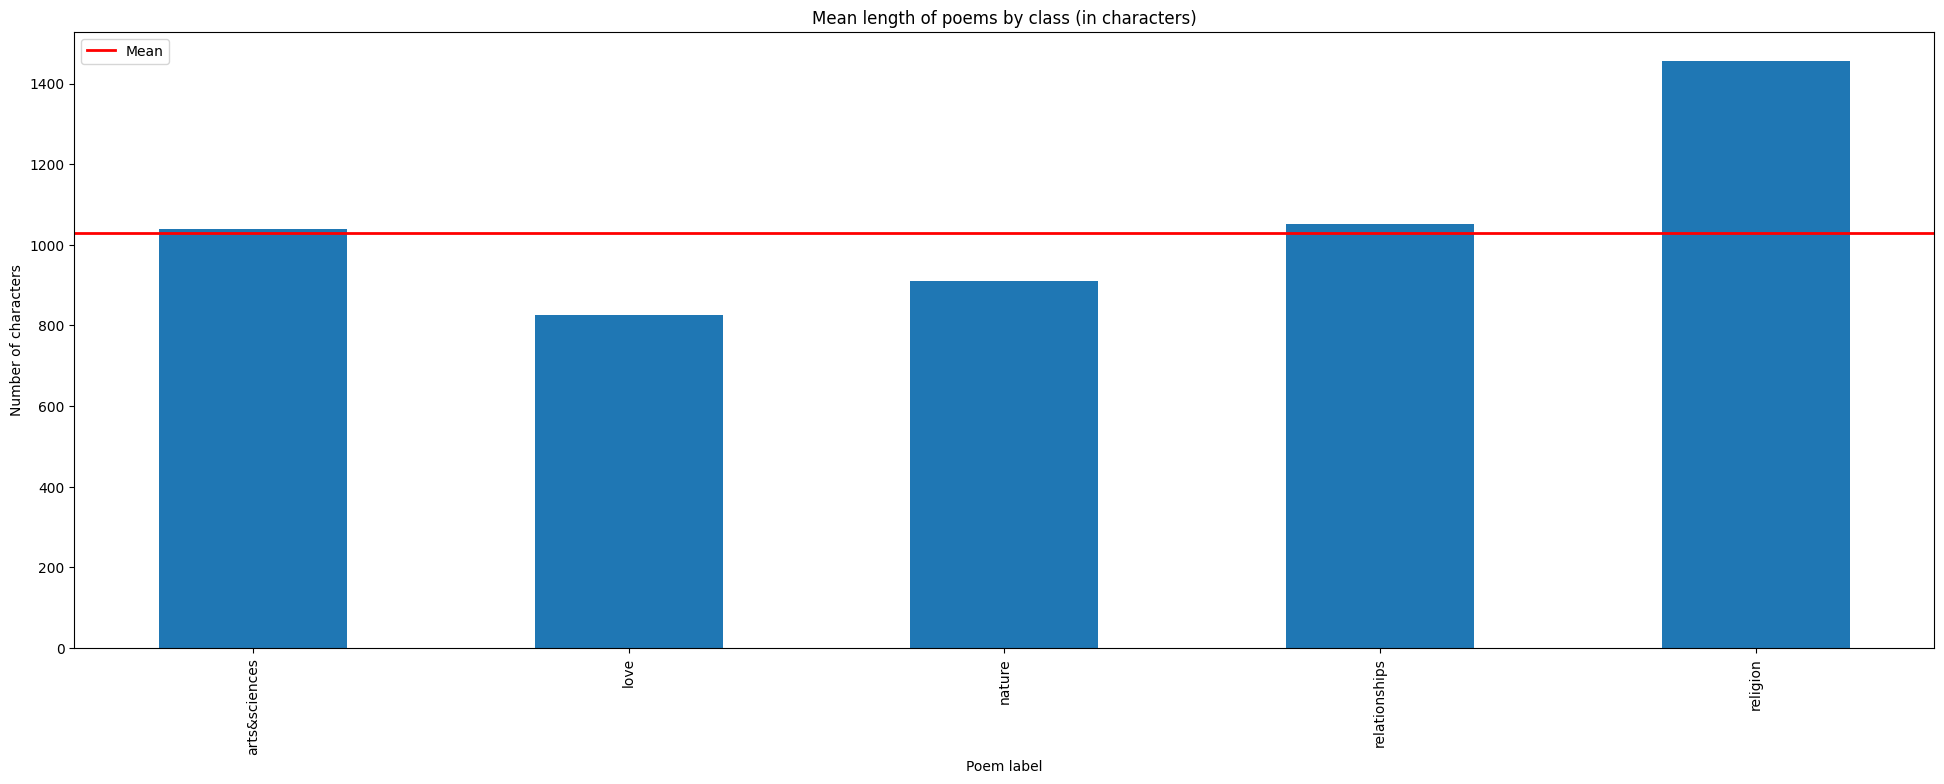

In [6]:
df_mean_length = text_df.groupby('topic').mean().reset_index()

plt.figure(figsize=(24, 8))
plt.bar(x=df_mean_length["topic"], height=df_mean_length["len"], width=0.5)

plt.xlabel('Poem label')
plt.ylabel('Number of characters')
plt.title('Mean length of poems by class (in characters)')
plt.axhline(y=int(text_df['len'].mean()), color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)

plt.show()

Since almost all classes have poems of same length, it won't be an useful feature to use.

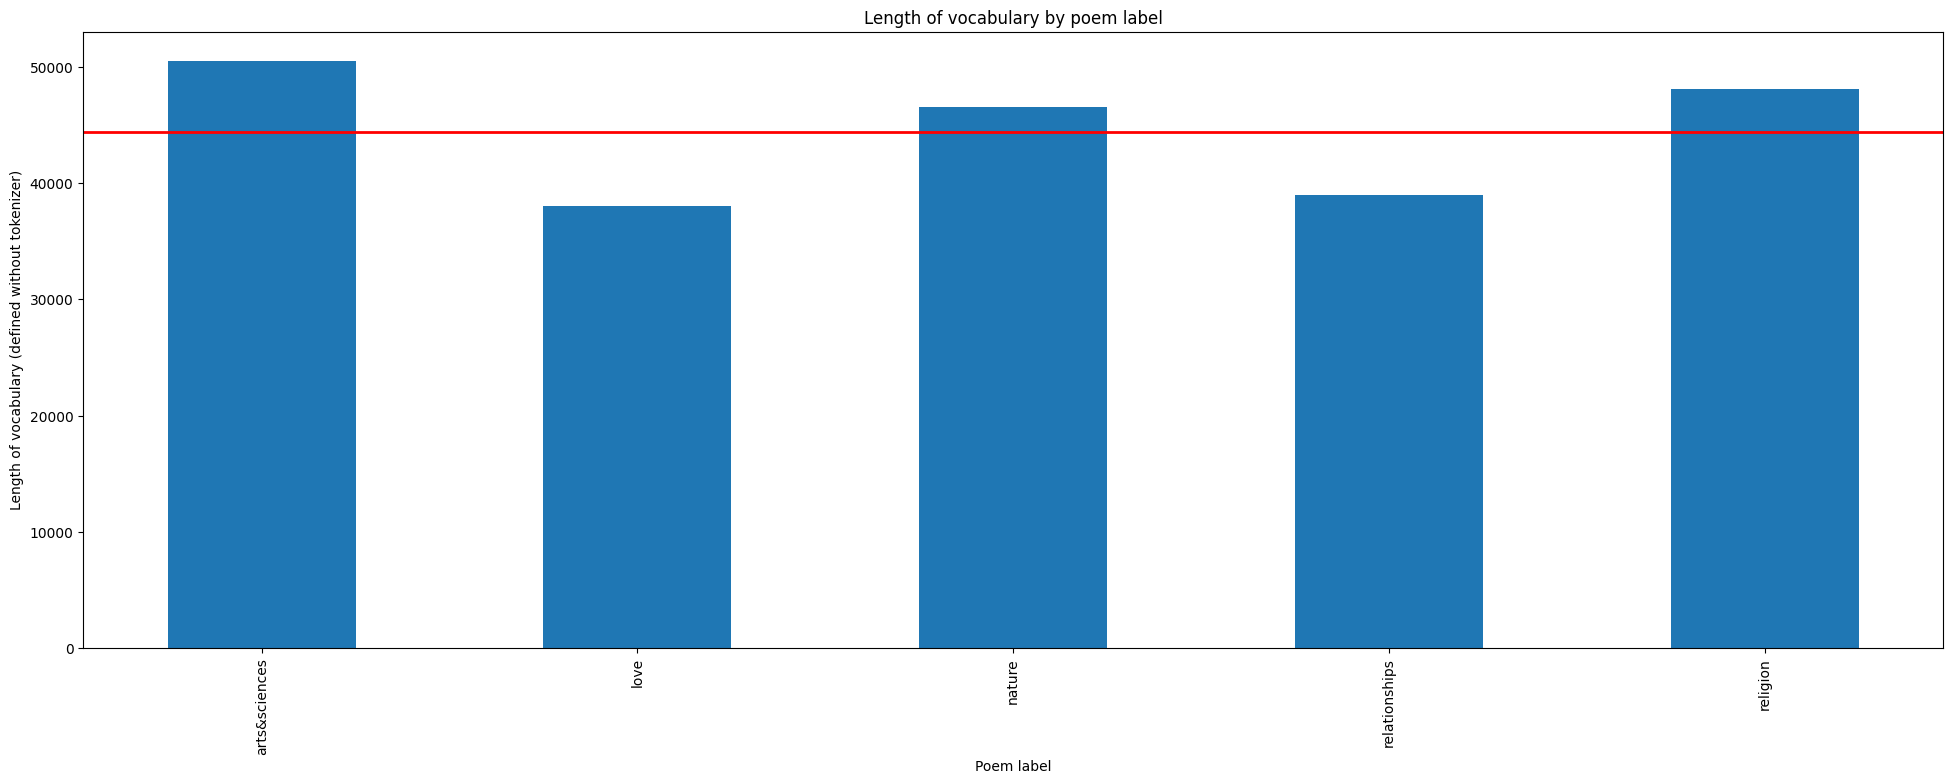

In [7]:
vocab_length_by_label = []
most_occuring_words_by_label = []
labels = np.unique(df["topic"])
for label in labels:
    voc_tmp = " ".join(list(df[df["topic"] == label]["poem"])).split()
    vocab_length_by_label.append(len(set(voc_tmp)))
    u, count = np.unique(voc_tmp, return_counts=True)
    count_sort_ind = np.argsort(-count)
    most_occuring_words_by_label.append((u[count_sort_ind][:5], count[count_sort_ind][:5]))

plt.figure(figsize=(24, 8))
plt.bar(x=labels, height=vocab_length_by_label, width=0.5)
plt.xlabel('Poem label')
plt.ylabel('Length of vocabulary (defined without tokenizer)')
plt.title('Length of vocabulary by poem label')

plt.axhline(y=statistics.mean(vocab_length_by_label), color='r', linestyle='-', linewidth=2, label='Mean')
plt.xticks(rotation=90)

plt.show()

In [8]:
for i in range(len(labels)):
    print(f"{labels[i]} : ", end="")
    tmp = most_occuring_words_by_label[i]
    for i in range(5):
        print(f"{tmp[1][i]} occurence(s) of {tmp[0][i]}", end=", ")
    print()
    

arts&sciences : 2625 occurence(s) of like, 2099 occurence(s) of one, 980 occurence(s) of would, 974 occurence(s) of us, 908 occurence(s) of know, 
love : 2373 occurence(s) of love, 2312 occurence(s) of like, 1610 occurence(s) of one, 885 occurence(s) of us, 875 occurence(s) of would, 
nature : 2775 occurence(s) of like, 1940 occurence(s) of one, 987 occurence(s) of us, 951 occurence(s) of light, 929 occurence(s) of back, 
relationships : 2601 occurence(s) of like, 1927 occurence(s) of one, 1044 occurence(s) of back, 1010 occurence(s) of us, 962 occurence(s) of time, 
religion : 2027 occurence(s) of like, 1866 occurence(s) of one, 1651 occurence(s) of god, 1366 occurence(s) of thy, 1312 occurence(s) of us, 


As we can see, there is a lot of diversity in the most used words for each category, so a CountVectorizer might be a good start for embedding.

## Logistic Regression

### CountVectorizer

In [9]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['poem'])

In [10]:
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42, solver='saga')
model.fit(X_train, y_train)

c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [12]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4757    0.4444    0.4596       441
         love     0.5240    0.6122    0.5647       410
       nature     0.4895    0.6034    0.5405       464
relationships     0.4579    0.3696    0.4090       368
     religion     0.5766    0.4400    0.4991       325

     accuracy                         0.5010      2008
    macro avg     0.5048    0.4939    0.4946      2008
 weighted avg     0.5018    0.5010    0.4969      2008



Very bad result, might try with lemmatization.

In [13]:
lemmatizer = WordNetLemmatizer()
df["poem"] = df["poem"].apply(lambda poem: " ".join([lemmatizer.lemmatize(word) for word in poem.split()]))

In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['poem'])

In [16]:
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42, solver='saga')
model.fit(X_train, y_train)

c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [18]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4865    0.4490    0.4670       441
         love     0.5257    0.6244    0.5708       410
       nature     0.4928    0.5884    0.5363       464
relationships     0.4815    0.3886    0.4301       368
     religion     0.5665    0.4585    0.5068       325

     accuracy                         0.5075      2008
    macro avg     0.5106    0.5018    0.5022      2008
 weighted avg     0.5080    0.5075    0.5039      2008



In [20]:
X = df['poem']
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = make_pipeline(CountVectorizer(tokenizer=word_tokenize), LogisticRegression(max_iter=1000, random_state=42, multi_class="multinomial", solver='saga'))
model.fit(X_train, y_train)

c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(tokenizer=<function word_tokenize at 0x00000291874323B0>)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42, solver='saga'))])

In [22]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4706    0.4354    0.4523       441
         love     0.5283    0.6146    0.5682       410
       nature     0.4870    0.6034    0.5390       464
relationships     0.4582    0.3723    0.4108       368
     religion     0.5743    0.4400    0.4983       325

     accuracy                         0.5000      2008
    macro avg     0.5037    0.4931    0.4937      2008
 weighted avg     0.5007    0.5000    0.4958      2008



### tf-idf

In [23]:
X = df['poem']
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression(multi_class="multinomial", max_iter=500, solver="saga", random_state=42))
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, multi_class='multinomial',
                                    random_state=42, solver='saga'))])

In [31]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4839    0.5125    0.4978       441
         love     0.5910    0.5780    0.5845       410
       nature     0.4696    0.6983    0.5615       464
relationships     0.5397    0.3696    0.4387       368
     religion     0.6667    0.4062    0.5048       325

     accuracy                         0.5254      2008
    macro avg     0.5502    0.5129    0.5175      2008
 weighted avg     0.5423    0.5254    0.5205      2008



### word2vec

In [32]:
import gensim.downloader

word2vec = gensim.downloader.load('word2vec-google-news-300')

#### Above is the code to discover these weird lines

In [120]:
def transform_X(serie: pd.Series):
    X = []
    indices_to_skip = []
    i = 0
    for e in serie:
        e_w2v = np.array([word2vec[word] for word in e.split() if word in word2vec])
        if len(e_w2v) == 0:
            print(e)
            indices_to_skip.append(i)
            i += 1
            continue
        X.append(np.mean(e_w2v, axis=0))
        i += 1
    return np.array(X), indices_to_skip

X_w2v, indices_to_skip = transform_X(df["poem"])

আমাদের মেসে ইমদাদ হক ফুটবল খেলোয়াড় হাতে পায়ে মুখে শত আঘাতের ক্ষতে খ্যাতি লেখা তার। সন্ধ্যা বেলায় দেখিবে তাহারে পটি বাঁধি পায়ে হাতে মালিশ মাখিছে প্রতি গিঠে গিঠে কাত হয়ে বিছানাতে। মেসের চাকর হয় লবেজান সেঁক দিতে ভাঙ্গা হাড়ে সারা রাত শুধু ছটফট করে কেঁদে কেঁদে ডাক ছাড়ে। আমরা তো ভাবি ছমাসের তরে পঙ্গু সে হল হায় ফুটবলটিমে বল লয়ে কভু দেখিতে পাব না তায়। প্রভাত বেলায় খবর লইতে ছুটে যাই তার ঘরে বিছানা তাহার শূন্য পড়িয়া ভাঙা খাটিয়ার পরে। টেবিলের পরে ছোট বড় যত মালিশের শিশিগুলি উপহাস যেন করিতেছে মোরে ছিপি পরা দাঁত তুলি। সন্ধ্যা বেলায় খেলার মাঠেতে চেয়ে দেখি বিস্ময়ে মোদের মেসের ইমদাদ হক আগে ছোটে বল লয়ে বাপ পায়ে বল ড্রিবলিং করে ডান পায়ে মারে ঠেলা ভাঙা কয়খানা হাতে পায়ে তার বজ্র করিছে খেলা। চালাও চালাও আরও আগে যাও বাতাসের মত ধাও মারো জোরে মারো গোলের ভেতরে বলেরে ছুঁড়িয়া দাও। গোলগোলগোল চারিদিক হতে ওঠে কোলাহলকল জীবনের পণ মরণের পণ সব বাঁধা পায়ে দল। গোলগোলগোলমোদের মেসের ইমদাদ হক কাজি ভাঙা দুটি পায়ে জয়ের ভাগ্য লুটিয়া আনিল আজি। দর্শকদল ফিরিয়া চলেছে মহাকলবর করে ইমদাদ হক খোড়াতে খোড়

In [122]:
print(df["poem"][3992])

আমাদের মেসে ইমদাদ হক ফুটবল খেলোয়াড় হাতে পায়ে মুখে শত আঘাতের ক্ষতে খ্যাতি লেখা তার। সন্ধ্যা বেলায় দেখিবে তাহারে পটি বাঁধি পায়ে হাতে মালিশ মাখিছে প্রতি গিঠে গিঠে কাত হয়ে বিছানাতে। মেসের চাকর হয় লবেজান সেঁক দিতে ভাঙ্গা হাড়ে সারা রাত শুধু ছটফট করে কেঁদে কেঁদে ডাক ছাড়ে। আমরা তো ভাবি ছমাসের তরে পঙ্গু সে হল হায় ফুটবলটিমে বল লয়ে কভু দেখিতে পাব না তায়। প্রভাত বেলায় খবর লইতে ছুটে যাই তার ঘরে বিছানা তাহার শূন্য পড়িয়া ভাঙা খাটিয়ার পরে। টেবিলের পরে ছোট বড় যত মালিশের শিশিগুলি উপহাস যেন করিতেছে মোরে ছিপি পরা দাঁত তুলি। সন্ধ্যা বেলায় খেলার মাঠেতে চেয়ে দেখি বিস্ময়ে মোদের মেসের ইমদাদ হক আগে ছোটে বল লয়ে বাপ পায়ে বল ড্রিবলিং করে ডান পায়ে মারে ঠেলা ভাঙা কয়খানা হাতে পায়ে তার বজ্র করিছে খেলা। চালাও চালাও আরও আগে যাও বাতাসের মত ধাও মারো জোরে মারো গোলের ভেতরে বলেরে ছুঁড়িয়া দাও। গোলগোলগোল চারিদিক হতে ওঠে কোলাহলকল জীবনের পণ মরণের পণ সব বাঁধা পায়ে দল। গোলগোলগোলমোদের মেসের ইমদাদ হক কাজি ভাঙা দুটি পায়ে জয়ের ভাগ্য লুটিয়া আনিল আজি। দর্শকদল ফিরিয়া চলেছে মহাকলবর করে ইমদাদ হক খোড়াতে খোড়

In [121]:
print(indices_to_skip)

[3992, 9431, 11216, 12517, 12604]


In [103]:
test = np.array([word2vec[word] for word in df["poem"][9439].split() if word in word2vec])

In [94]:
print(df["poem"][9431].split())

['world', 'people', 'people', 'different', 'religion', 'religion', 'various', 'festivals', 'festivals', 'celebrated', 'joy', 'year', 'people', 'poverty', 'could', 'celebrate', 'farmers', 'produce', 'food', 'country', 'could', 'celebrate', 'people', 'buys', 'food', 'farmers', 'enjoys', 'festival', 'people', 'money', 'people', 'tradition', 'could', 'celebrate', 'sometimes', 'poverty', 'makes', 'people', 'go', 'wrong', 'way', 'somewhere', 'poverty', 'lead', 'suicide', 'makes', 'poverty', 'controlling', 'wastage', 'food', 'country', 'may', 'avoid', 'poverty', 'controlling', 'wastage', 'money', 'country', 'sometimes', 'somewhere', 'things', 'needed', 'reach', 'people', 'poverty', 'doesnt', 'reach', 'although', 'people', 'donate', 'sometimes', 'donation', 'done', 'status', 'people', 'poverty', 'fulfilled', 'since', 'poverty', 'abolished']


### back to word2vec

In [43]:
def transform_X(serie: pd.Series):
    tmp = [np.mean(np.array([word2vec[word] for word in poem.split() if word in word2vec]), axis=0) for poem in serie]
    cleaned = []
    ind = []
    i = 0
    for e in tmp:
        if e.shape != ():
            cleaned.append(e)
        else:
            ind.append(i)
        i += 1
    return np.array(cleaned), ind

X_w2v, ind = transform_X(df["poem"])

c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [46]:
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [47]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, solver="saga", random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [48]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.5021    0.5525    0.5261       438
         love     0.5573    0.5220    0.5390       410
       nature     0.5328    0.6588    0.5891       469
relationships     0.5204    0.4536    0.4847       366
     religion     0.5720    0.4277    0.4894       325

     accuracy                         0.5329      2008
    macro avg     0.5369    0.5229    0.5257      2008
 weighted avg     0.5352    0.5329    0.5300      2008



### With own word2vec

In [49]:
X = df['poem']
y = df['topic']

In [50]:
L = []
for v in X:
    L.append(v.split())

In [51]:
word2vec = Word2Vec(sentences=L, vector_size=500, min_count=1, workers=4)

In [52]:
def transform_X(serie: pd.Series):
    return np.array([np.mean(np.array([word2vec.wv[word] for word in poem.split() if word in word2vec.wv]), axis=0) for poem in serie])

X_w2v = transform_X(df["poem"])
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [54]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, solver="saga", random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [55]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.3862    0.4726    0.4251       438
         love     0.4848    0.4268    0.4540       410
       nature     0.4621    0.6247    0.5313       469
relationships     0.4363    0.3743    0.4029       366
     religion     0.5399    0.2708    0.3607       325

     accuracy                         0.4482      2008
    macro avg     0.4619    0.4339    0.4348      2008
 weighted avg     0.4581    0.4482    0.4413      2008



## Naive Bayes

In [56]:
X = df['poem']
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Countvectorizer

In [57]:
model = make_pipeline(CountVectorizer(), MultinomialNB(alpha=0.08))
model.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=0.08))])

In [58]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4400    0.3767    0.4059       438
         love     0.4849    0.3537    0.4090       410
       nature     0.4830    0.5757    0.5253       469
relationships     0.3594    0.4891    0.4144       366
     religion     0.4043    0.3446    0.3721       325

     accuracy                         0.4338      2008
    macro avg     0.4343    0.4280    0.4253      2008
 weighted avg     0.4388    0.4338    0.4305      2008



### Tf-idf

In [59]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=2.9))
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=2.9))])

In [60]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.5090    0.2580    0.3424       438
         love     0.5576    0.3659    0.4418       410
       nature     0.3018    0.9446    0.4574       469
relationships     0.6250    0.0546    0.1005       366
     religion     1.0000    0.0523    0.0994       325

     accuracy                         0.3700      2008
    macro avg     0.5987    0.3351    0.2883      2008
 weighted avg     0.5711    0.3700    0.3061      2008



word2vec impossible since multinomial works with discrete valus

# Test

In [69]:
df_sentiment = pd.read_csv("../data_raw/train.tsv", delimiter='\t')

In [70]:
df_sentiment

,0,with pale blue berries. in these peaceful shades--,1
0,1,"it flows so long as falls the rain,",0
1,2,"and that is why, the lonesome day,",-1
2,3,"when i peruse the conquered fame of heroes, an...",2
3,4,of inward strife for truth and liberty.,2
4,5,the red sword sealed their vows!,2
...,...,...,...
743,887,to his ears there came a murmur of far seas be...,0
744,888,"the one good man in the world who knows me, --",1
745,889,faint voices lifted shrill with pain,-1
746,890,"an', fust you knowed on, back come charles the...",0
